# CA3

### Imports

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

### Reading data

In [42]:
df = pd.read_csv("./assets/train.csv", index_col = 0)

df.info()

# Checking for missing values
print(f"\nMissing values inn training data: {df.isnull().sum().sum()}")

<class 'pandas.core.frame.DataFrame'>
Index: 2800 entries, -1.8257343 to -1.6260979
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Weight          2800 non-null   float64
 1   Sweetness       2800 non-null   float64
 2   Softness        2800 non-null   float64
 3   HarvestTime     2800 non-null   float64
 4   Ripeness        2800 non-null   float64
 5   Acidity         2800 non-null   float64
 6   Peel Thickness  2800 non-null   float64
 7   Banana Density  2800 non-null   float64
 8   Quality         2800 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 218.8 KB

Missing values inn training data: 0


### Data exploration and visualisation

            Weight    Sweetness     Softness  HarvestTime     Ripeness  \
count  2800.000000  2800.000000  2800.000000  2800.000000  2800.000000   
mean     -0.751050    -0.751005    -0.019557    -0.700683     0.771011   
std       2.006590     1.955109     2.076865     2.029916     2.098275   
min      -7.103426    -6.434022    -6.959320    -7.570008    -7.423155   
25%      -2.238843    -2.104742    -1.593816    -2.112747    -0.572589   
50%      -0.882387    -0.997902     0.220174    -0.856858     0.930927   
75%       0.853566     0.334989     1.542899     0.628895     2.229410   
max       5.679692     6.438196     8.241555     5.942060     7.077372   

           Acidity  Peel Thickness  Banana Density      Quality  
count  2800.000000     2800.000000     2800.000000  2800.000000  
mean     -0.000989        0.506758    49397.491271     0.506429  
std       2.286725        0.291936    29327.077623     0.500048  
min      -8.226977        0.000086     -980.343999     0.000000  
25%

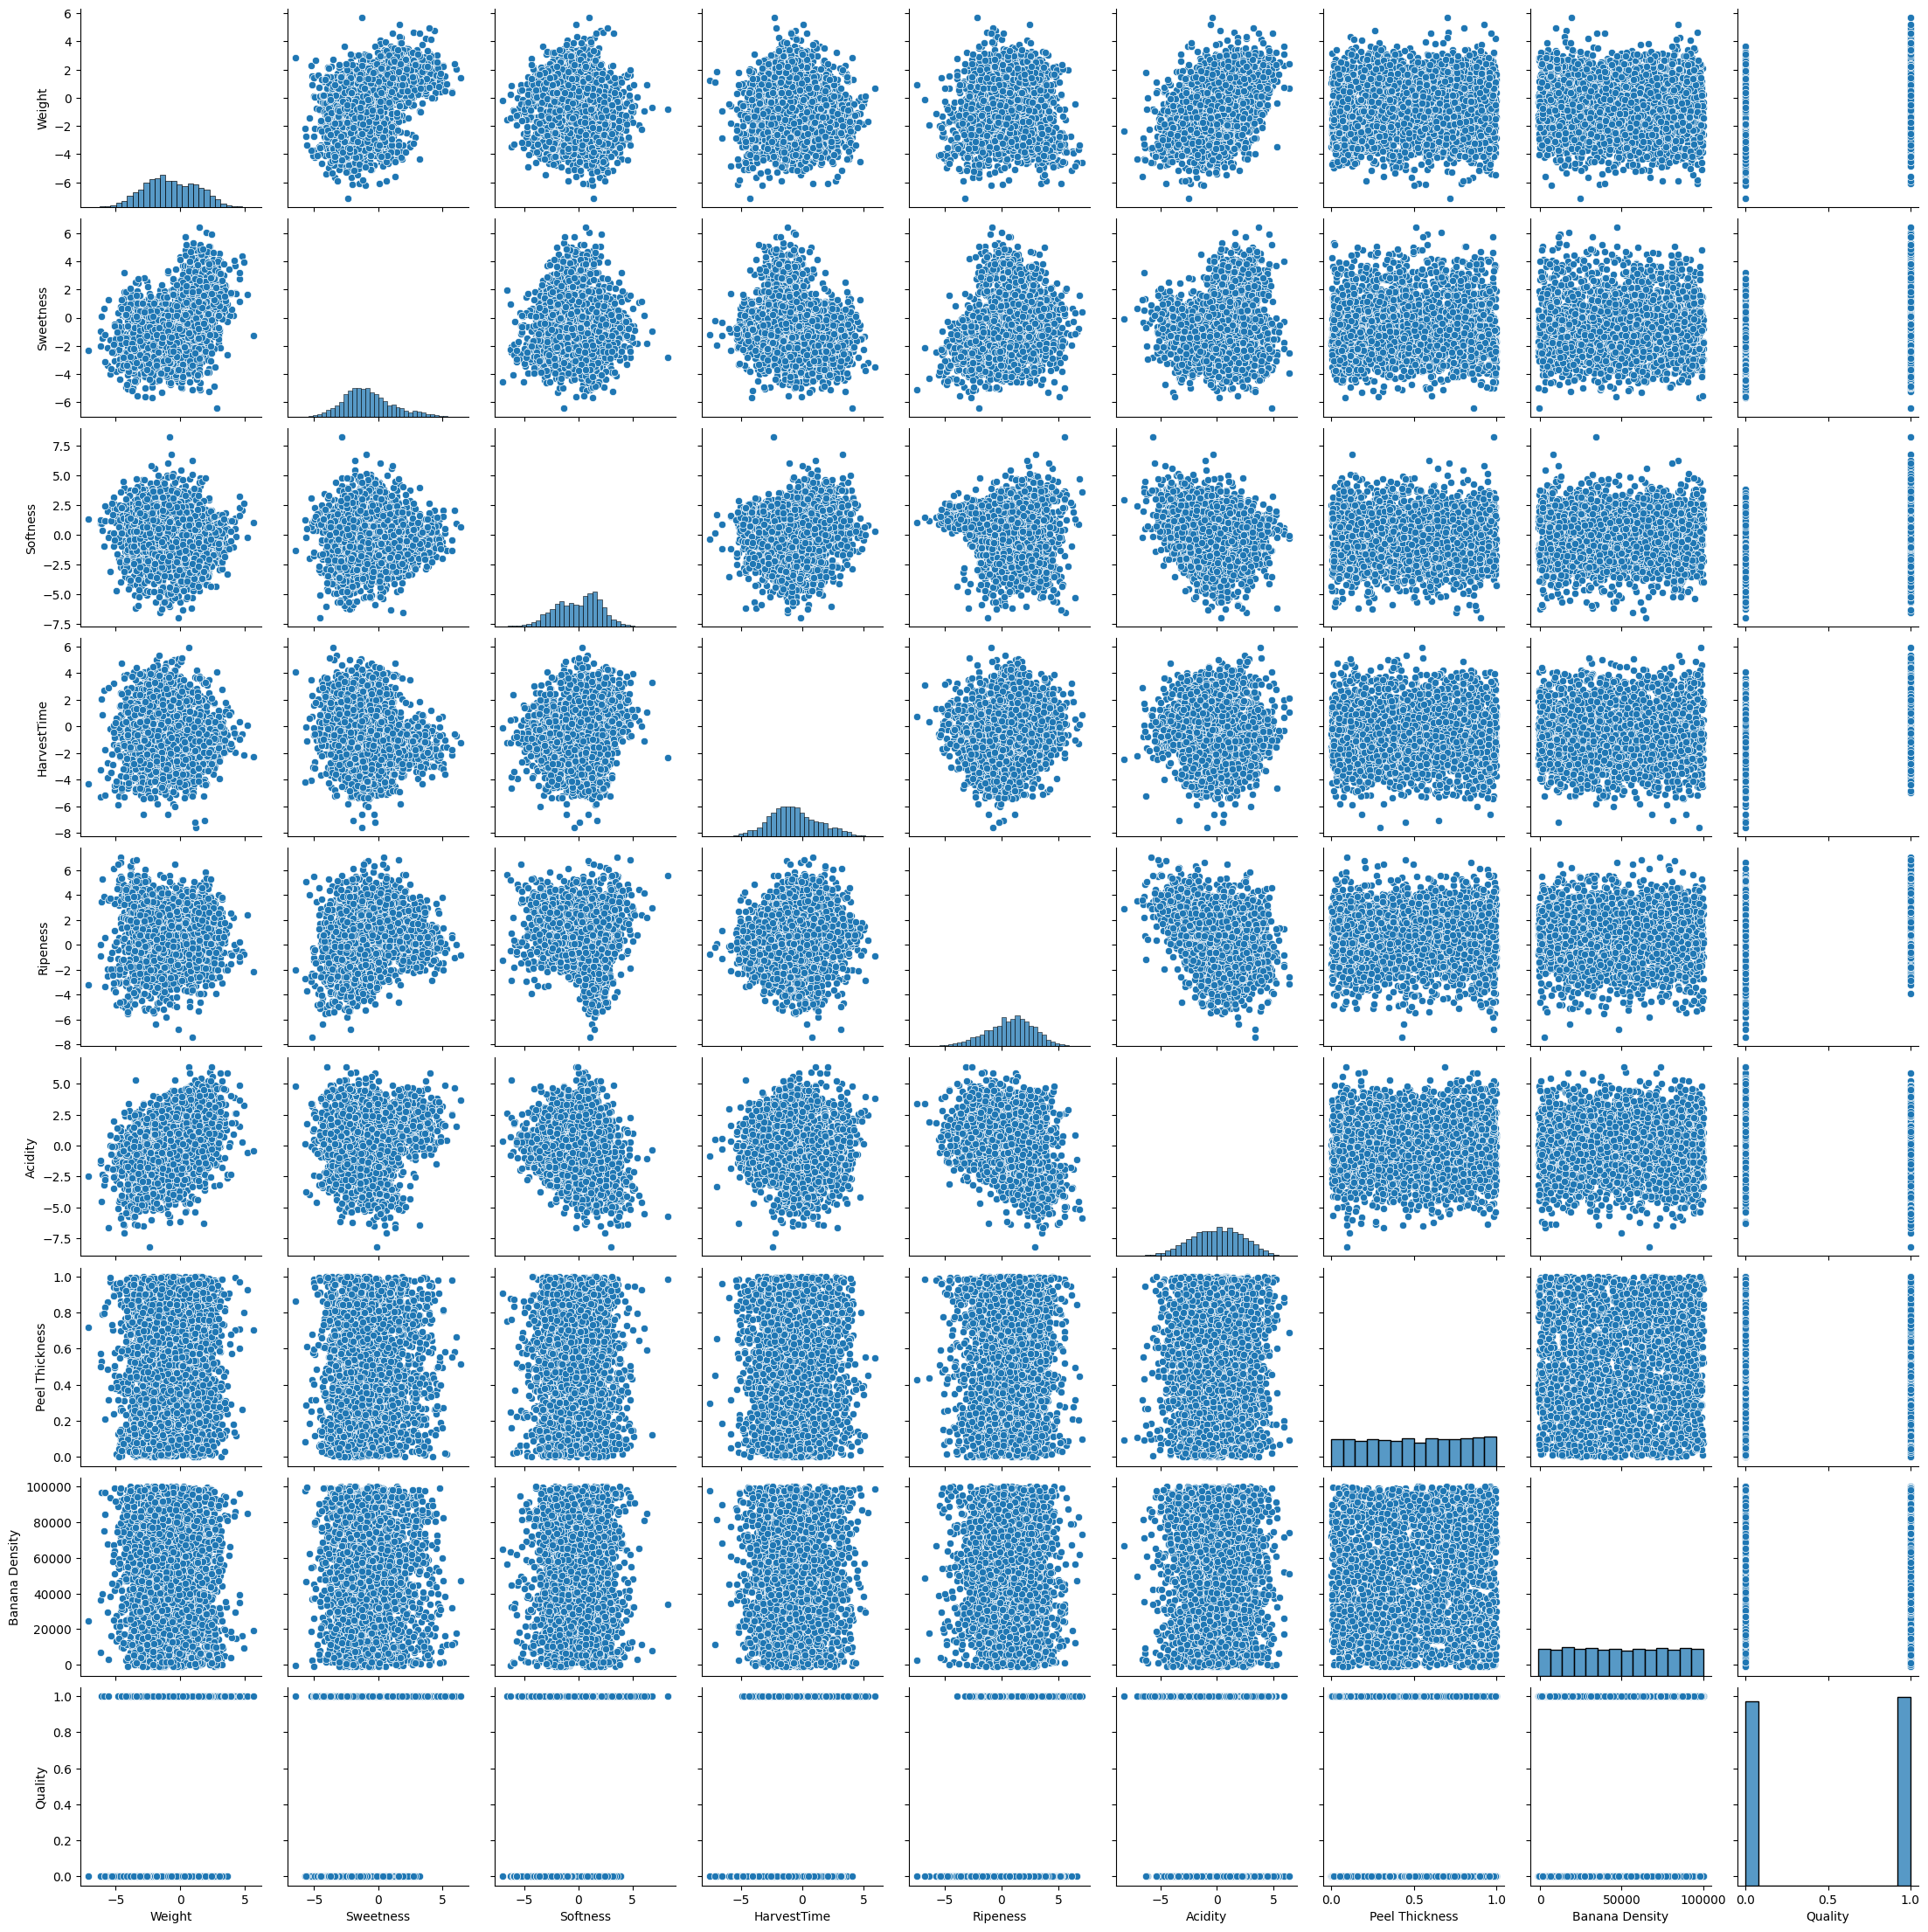

In [43]:
print(df.describe()) # Gives a table of the dataset with statistical components like mean and quantiles

sns.pairplot(df) # Gives a scatter plot for every pair & a histogram for the the feature paired with itself

The pairs of different features does not look linear seperable, they have a complex relation.  
Therefore, we think models like logistic regression will have low accuracy for theese data.

<Axes: >

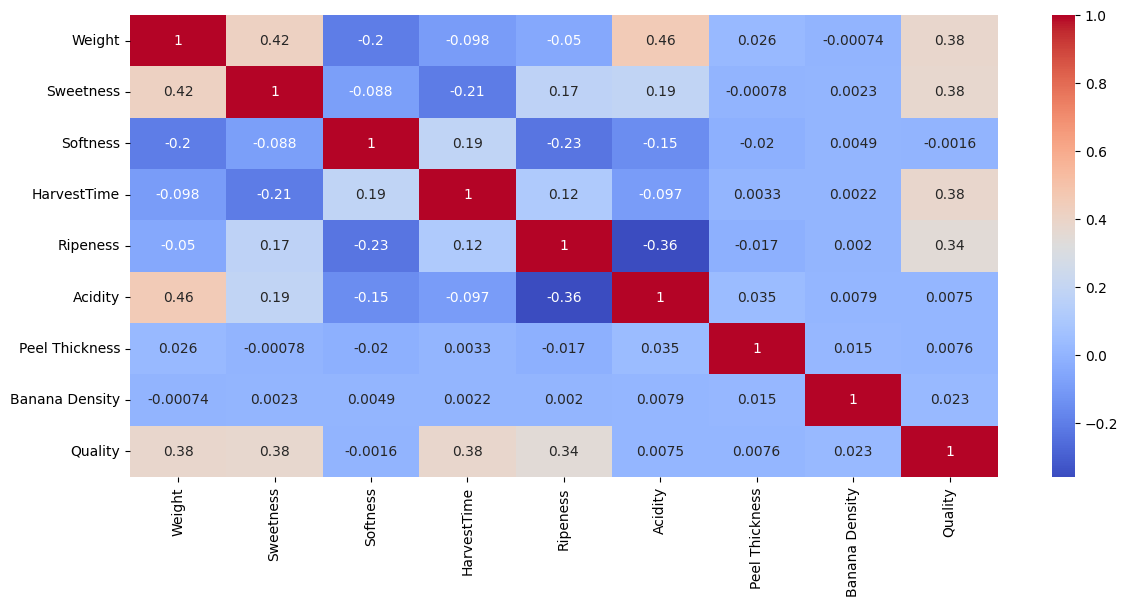

In [44]:
""" Checking correlation with every feature """
fig, axes = plt.subplots(1, 1, figsize=(14, 6)) # To make the values more readable
# annot = true to get value, coolwarm cmap to make sense with correlation
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm") 

As we can see: Acidity and Weight, and Weight and Sweetness has the highest positive correlation.  
While the Acidity and Ripeness, and Softness and Ripeness has the highest negative correlation.  

##### To conclude:  
The pairs of different features have complex relations to each other. The data is not linearly seperable and  
therefore, we think models like logistic regression will have low accuracy for theese data.  
Acidity and Weight, Weight and Sweetness has the highest positive correlation.  
While the Acidity and Ripeness, and Softness and Ripeness has the highest negative correlation.  
With this informasjotion we know which features we can focus more on.  
We also found out that the banana density values are too high. We want to scale and standardize  
the values of the dataset to fit the models better.  
We will probably remove the coloumns banana density and peel thickness because of the low correlation  
to the other features.  
We think that SVC, KNN and Randomforest will be the better models, therefore,  
we will only train those models.

### Data Preprocessing & Feature Engineering

We found out in the exploration and visualization part that there were not any missing values.  
However, we will still drop outliers if we find any.  
  
Feature Selection: We saw that Banana Density and Peel Thickness has low correlation with other features.  
Therefore we will drop those features

In [45]:
# Feature Selection, we are dropping the features when we're dropping coloumns in splitting data
useless_features = ["Banana Density", "Peel Thickness"]

# Including outliers, we found out that our model gets worse by removing outliers

df_clean = df.copy()
X = df_clean.drop(columns = ["Quality"] + useless_features)
y = df_clean["Quality"]

### Modelling

##### Finding good parameters

##### SVC

In [ ]:
# Set ranges for C and gamma
params_C = np.arange(-1.6, 2, 0.1)
params_gamma = np.arange(0.1, 0.6, 0.1)

# Collect results in numpy arrays, one for train, one for test
svc_list = np.empty((len(params_C), len(params_gamma)), dtype = object) # Makes an empty multidimentional array
accArr_test = np.zeros((len(params_C), len(params_gamma)))

for c_ind, c in enumerate(params_C):
    for gamma_ind, gamma_val in enumerate(params_gamma):

        accTest_list = []
        for r in range(42, 52):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = r, stratify = y)

            sc = StandardScaler()
            sc.fit(X_train)

            X_train_sc = sc.transform(X_train)
            X_test_sc = sc.transform(X_test)

            SVC_rbf = SVC(kernel='rbf', C = 10.**c, gamma = gamma_val, random_state = 1)
            SVC_rbf.fit(X_train_sc, y_train)

            test_acc = SVC_rbf.score(X_test_sc, y_test)
            accTest_list.append(test_acc)

        accTest_average = np.mean(accTest_list)

        svc_list[c_ind, gamma_ind] = SVC_rbf
        accArr_test[c_ind, gamma_ind] = accTest_average


# Calculate and print the best parameters for the test data
best_params = np.unravel_index(accArr_test.argmax(), accArr_test.shape)
best_svc = svc_list[best_params[0], best_params[1]]

print('Best parameters for test data:')
print('c = {0:.2f}'.format(params_C[best_params[0]]))
print('gamma = {0:.2f}'.format(params_gamma[best_params[1]]))
print('with accuracy: {0:.3f}'.format(accArr_test[best_params[0], best_params[1]]))

Best parameters for test data:
c = 0.10
gamma = 0.30
with accuracy: 0.974


##### Random Forest


In [77]:
params_n_e = np.arange(1, 101, 5)
params_n_j = np.arange(1, 5, 1)
params_depth = np.arange(1, 5, 1)

random_forest_classifiers = np.empty((len(params_n_e), len(params_n_j), len(params_depth)), dtype = object)
accArr_test = np.zeros((len(params_n_e), len(params_n_j), len(params_depth)))

for n_e_ind, n_e in enumerate(params_n_e):
    for n_j_ind, n_j in enumerate(params_n_j):
        for depth_ind, depth in enumerate(params_depth):
            accTest_list = []

            for r in range(42, 52):

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = r)

                sc = StandardScaler()
                sc.fit(X_train)

                X_train_sc = sc.transform(X_train)
                X_test_sc = sc.transform(X_test)

                # Train the model
                clf = RandomForestClassifier(n_estimators = n_e, random_state = 42, n_jobs = n_j, max_depth = depth, criterion = 'gini')
                clf.fit(X_train_sc, y_train)

                test_acc = clf.score(X_test_sc, y_test)
                accTest_list.append(test_acc)
            
            accTest_average = np.mean(accTest_list)

            random_forest_classifiers[n_e_ind, n_j_ind, depth_ind] = clf
            accArr_test[n_e_ind, n_j_ind, depth_ind] = accTest_average


# Calculate and print the best parameters for the test data

best_params = np.unravel_index(accArr_test.argmax(), accArr_test.shape)
best_rfc = random_forest_classifiers[best_params[0], best_params[1], best_params[2]]

print('Best parameters for test data:')
print('n estimatiors = {0:.2f}'.format(params_n_e[best_params[0]]))
print('n jobs = {0:.2f}'.format(params_n_j[best_params[1]]))
print('max depth = {0:.2f}'.format(params_depth[best_params[2]]))
print('with accuracy: {0:.3f}'.format(accArr_test[best_params[0], best_params[1], best_params[2]]))

Best parameters for test data:
n estimatiors = 66.00
n jobs = 1.00
max depth = 4.00
with accuracy: 0.894


##### KNN

In [78]:
best_k = 0
best_accuracy = 0

for k in range(1, 15):
    accuracies = []
    
    for r in range(100):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = r)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        knn = KNeighborsClassifier(n_neighbors = k)
        y_pred = knn.fit(X_train_scaled, y_train).predict(X_val_scaled)
        accuracy = accuracy_score(y_pred, y_val)
        accuracies.append(accuracy)

    accuracy = np.mean(accuracies)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Best k: {best_k}, Best accuracy during optimization: {best_accuracy:.3f}")

X_test_scaled = scaler.transform(X_test)
y_pred_final = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_pred_final, y_test)

print(f"Final accuracy of {best_k}-NN on the test set: {accuracy:.3f}")


Best k: 11, Best accuracy during optimization: 0.970
Final accuracy of 11-NN on the test set: 0.979


### Final evaluation

SVC  
C = 10 ** 0.1, gamma = 0.30,  
with an accuracy 97.4%

### Kaggle submission

In [81]:
# Our best model.
model = best_svc

# Getting our test data and dropping useless features.
df_test = pd.read_csv("./assets/test.csv", index_col = 0)
df_test = df_test.drop(columns = useless_features)

# Scaling
X_test2_scaled = scaler.transform(df_test)

# Taken from the kaggle submission side.
y_test2 = model.predict(X_test2_scaled)
y_test2 = pd.DataFrame(y_test2, columns=["Quality"])
y_test2.index.name = "ID"
y_test2[['Quality']].to_csv("submission.csv")